<a href="https://colab.research.google.com/github/SeunghyeChae/tmdhey/blob/main/GAN_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xray GAN

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision

- 생성자와 판별자를 연결하는 gan 네트워크를 만듦
 gan(x) = discriminator(generator(x))
- gan 네트워크는 잠재 공간의 벡터를 판별자의 평가로 매핑
- 판별자는 생성자가 잠재 공간의 벡터를 디코딩한 것이 얼마나 현실적인지를 평가
- '진짜'/'가짜' 레이블과 함께 진짜 이미지와 가짜 이미지 샘플을 사용해 판별자를 훈련함. 일반적인 이미지 분류 모델을 훈련하는 것과 동일
- 생성자를 훈련하려면 gan 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용함. (== 매 단계 마다 생성자에 의해 디코딩된 이미지를 판별자가 '진짜'로 분류하도록 만드는 방향으로 생성자의 가중치를 이동한다는 뜻). 즉, 판별자를 속이도록 생성자를 훈련

In [ ]:
# 생성자

# input: (batch_size * chs_in * hegith_in * width_in)
# Output: (batch_size, chs_out, hegith_out, width_out)
# h_out = (hegith_in -1) * stride - 2 * padding + kernel

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100, 
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            
            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            
            # Output Layer
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.main(x)
        return x

In [ ]:
# 판별자
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            
            # (batch_size, 1, 64, 64)
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=4,
                      stride=2,
                      padding=1, 
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 64, 32, 32)
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 128, 16, 16)
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 256, 8, 8)
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 512, 4, 4)
            nn.Conv2d(in_channels=512,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            
            # (batch_size, 1, 1, 1)
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        x = self.main(x)
        return x

In [ ]:
G = Generator()
G(torch.randn(12, 100, 1, 1)).shape

torch.Size([12, 1, 64, 64])

In [ ]:
D = Discriminator()
D(torch.randn(14, 1, 64, 64)).shape

torch.Size([14, 1, 1, 1])

In [ ]:
def build_data_loader(batch_size):
    dataset = torchvision.datasets.ImageFolder(
        root='/content/drive/MyDrive/cakd_colab/2차플젝/2차 데이터 원본/데이터 원본/image',
        # root='/content/drive/MyDrive/cakd_colab/python_practice/.kaggle',
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(64), 
            torchvision.transforms.CenterCrop(64), 
            torchvision.transforms.Grayscale(), 
            torchvision.transforms.ToTensor(), 
        ]))
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images):
    img = torchvision.utils.make_grid(images, normalize=True)
    npy_img = img.numpy()
    plt.imshow(np.transpose(npy_img, (1, 2, 0)),
               interpolation='nearest')
    plt.show()

In [ ]:
for data, _ in build_data_loader(5):
    test_images = data
    break
    
print(test_images.shape)
# show_images(test_images)

torch.Size([5, 1, 64, 64])


In [ ]:
compute_loss = nn.BCELoss()

In [ ]:
# # 얘로하면 좀 이상해요~ 120정도부터 이상해요
# n_epochs = 150
# batch_size = 5

# # 이걸로 하면 좀 빠를거같고 / 학습이 먼가 마무리 안된느낌... 뼈가 흐물한게 있음...
# n_epochs = 110
# batch_size = 15

# 이건 그 후에 해볼거예욤
n_epochs = 100
batch_size = 5


In [ ]:
gpu = torch.device(0)
G = G.to(gpu)
D = D.to(gpu)

In [ ]:
optimizer_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
data_loader = build_data_loader(batch_size)
test_noise = torch.randn((8, 100, 1, 1)).to(gpu)

Epoch: 0/100
Example images:


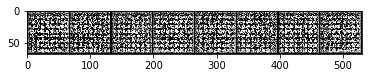

Epoch: 0	Batch: 496/497
Loss G: 5.128216743469238
Loss D: 0.10487835109233856
Epoch: 1/100
Example images:


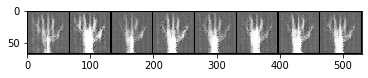

Epoch: 1	Batch: 496/497
Loss G: 3.7283730506896973
Loss D: 0.10130997747182846
Epoch: 2/100
Example images:


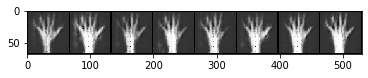

Epoch: 2	Batch: 496/497
Loss G: 6.209069728851318
Loss D: 0.015968434512615204
Epoch: 3/100
Example images:


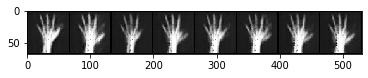

Epoch: 3	Batch: 496/497
Loss G: 5.455724239349365
Loss D: 0.09748760610818863
Epoch: 4/100
Example images:


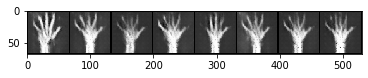

Epoch: 4	Batch: 496/497
Loss G: 6.645167827606201
Loss D: 0.010572997853159904
Epoch: 5/100
Example images:


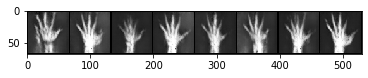

Epoch: 5	Batch: 496/497
Loss G: 4.406219482421875
Loss D: 0.23362256586551666
Epoch: 6/100
Example images:


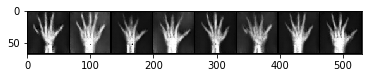

Epoch: 6	Batch: 496/497
Loss G: 4.621621608734131
Loss D: 0.06574910879135132
Epoch: 7/100
Example images:


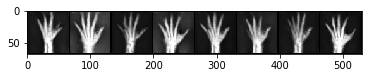

Epoch: 7	Batch: 496/497
Loss G: 7.6010589599609375
Loss D: 0.04609085991978645
Epoch: 8/100
Example images:


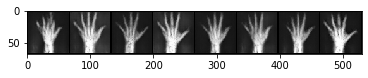

Epoch: 8	Batch: 496/497
Loss G: 3.9470202922821045
Loss D: 0.11506309360265732
Epoch: 9/100
Example images:


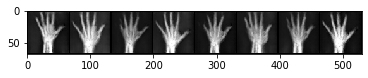

Epoch: 9	Batch: 496/497
Loss G: 5.9485883712768555
Loss D: 0.029075436294078827
Epoch: 10/100
Example images:


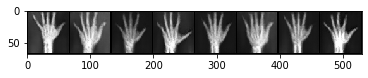

Epoch: 10	Batch: 496/497
Loss G: 7.156054973602295
Loss D: 0.010272955521941185
Epoch: 11/100
Example images:


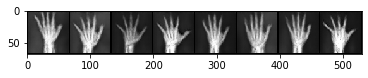

Epoch: 11	Batch: 496/497
Loss G: 13.072440147399902
Loss D: 0.016011696308851242
Epoch: 12/100
Example images:


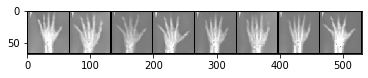

Epoch: 12	Batch: 496/497
Loss G: 7.726510524749756
Loss D: 0.11206017434597015
Epoch: 13/100
Example images:


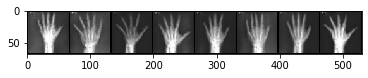

Epoch: 13	Batch: 496/497
Loss G: 8.062455177307129
Loss D: 0.02631838619709015
Epoch: 14/100
Example images:


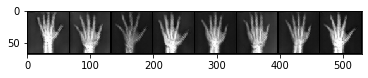

Epoch: 14	Batch: 496/497
Loss G: 8.660704612731934
Loss D: 0.008765318430960178
Epoch: 15/100
Example images:


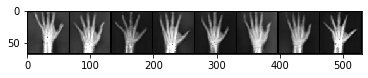

Epoch: 15	Batch: 496/497
Loss G: 7.164353847503662
Loss D: 0.7372581958770752
Epoch: 16/100
Example images:


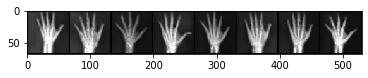

Epoch: 16	Batch: 496/497
Loss G: 6.712353706359863
Loss D: 0.008325448259711266
Epoch: 17/100
Example images:


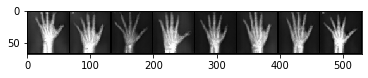

Epoch: 17	Batch: 496/497
Loss G: 6.146731853485107
Loss D: 0.013294009491801262
Epoch: 18/100
Example images:


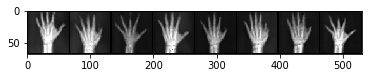

Epoch: 18	Batch: 496/497
Loss G: 4.314525127410889
Loss D: 0.04411116987466812
Epoch: 19/100
Example images:


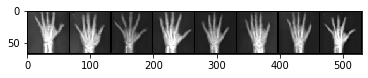

Epoch: 19	Batch: 496/497
Loss G: 8.302286148071289
Loss D: 0.022796286270022392
Epoch: 20/100
Example images:


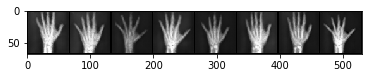

Epoch: 20	Batch: 496/497
Loss G: 5.04766845703125
Loss D: 0.08696597814559937
Epoch: 21/100
Example images:


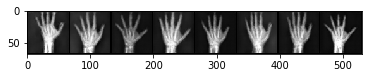

Epoch: 21	Batch: 496/497
Loss G: 8.39608097076416
Loss D: 0.002739942166954279
Epoch: 22/100
Example images:


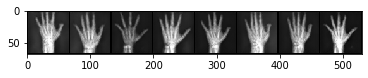

Epoch: 22	Batch: 496/497
Loss G: 6.281027317047119
Loss D: 0.012651246041059494
Epoch: 23/100
Example images:


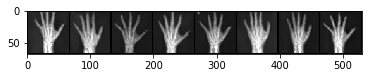

Epoch: 23	Batch: 496/497
Loss G: 5.164173126220703
Loss D: 0.007996526546776295
Epoch: 24/100
Example images:


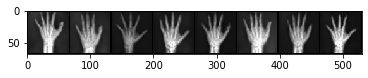

Epoch: 24	Batch: 496/497
Loss G: 8.184897422790527
Loss D: 0.0022616686765104532
Epoch: 25/100
Example images:


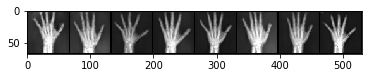

Epoch: 25	Batch: 496/497
Loss G: 8.572260856628418
Loss D: 0.3867102861404419
Epoch: 26/100
Example images:


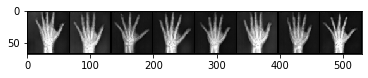

Epoch: 26	Batch: 496/497
Loss G: 11.397459983825684
Loss D: 0.0006731862085871398
Epoch: 27/100
Example images:


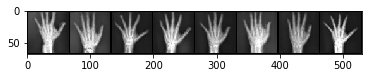

Epoch: 27	Batch: 496/497
Loss G: 11.015400886535645
Loss D: 0.024106213822960854
Epoch: 28/100
Example images:


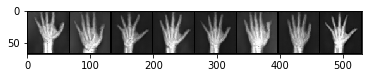

Epoch: 28	Batch: 496/497
Loss G: 5.173103332519531
Loss D: 0.015919113531708717
Epoch: 29/100
Example images:


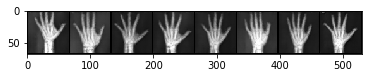

Epoch: 29	Batch: 496/497
Loss G: 6.19103479385376
Loss D: 0.006887196563184261
Epoch: 30/100
Example images:


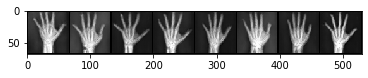

Epoch: 30	Batch: 496/497
Loss G: 8.94128704071045
Loss D: 0.037901315838098526
Epoch: 31/100
Example images:


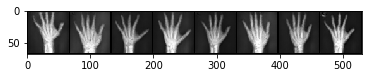

Epoch: 31	Batch: 496/497
Loss G: 5.952755928039551
Loss D: 0.007410705089569092
Epoch: 32/100
Example images:


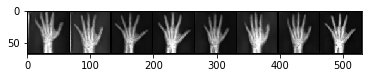

Epoch: 32	Batch: 496/497
Loss G: 5.423043727874756
Loss D: 0.027526715770363808
Epoch: 33/100
Example images:


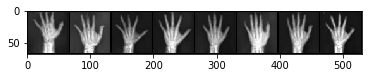

Epoch: 33	Batch: 496/497
Loss G: 8.222533226013184
Loss D: 0.002139866119250655
Epoch: 34/100
Example images:


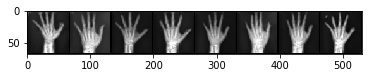

Epoch: 34	Batch: 496/497
Loss G: 6.463635444641113
Loss D: 0.006498595234006643
Epoch: 35/100
Example images:


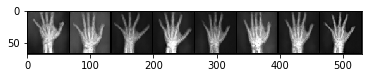

Epoch: 35	Batch: 496/497
Loss G: 6.927005290985107
Loss D: 0.0024522580206394196
Epoch: 36/100
Example images:


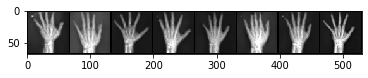

Epoch: 36	Batch: 496/497
Loss G: 12.716444969177246
Loss D: 0.3417555093765259
Epoch: 37/100
Example images:


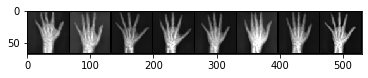

Epoch: 37	Batch: 496/497
Loss G: 5.804225921630859
Loss D: 0.027752647176384926
Epoch: 38/100
Example images:


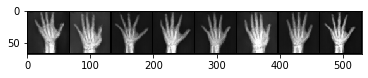

Epoch: 38	Batch: 496/497
Loss G: 17.987842559814453
Loss D: 1.4382989406585693
Epoch: 39/100
Example images:


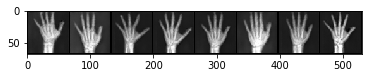

Epoch: 39	Batch: 496/497
Loss G: 10.794493675231934
Loss D: 0.0007594214985147119
Epoch: 40/100
Example images:


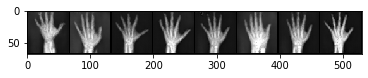

Epoch: 40	Batch: 496/497
Loss G: 6.531585693359375
Loss D: 0.021158386021852493
Epoch: 41/100
Example images:


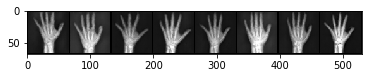

Epoch: 41	Batch: 496/497
Loss G: 9.078033447265625
Loss D: 0.0004860532353632152
Epoch: 42/100
Example images:


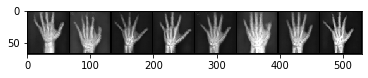

Epoch: 42	Batch: 496/497
Loss G: 5.930574893951416
Loss D: 0.08785383403301239
Epoch: 43/100
Example images:


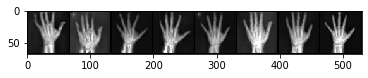

Epoch: 43	Batch: 496/497
Loss G: 5.303640842437744
Loss D: 0.005182974506169558
Epoch: 44/100
Example images:


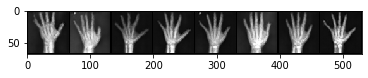

Epoch: 44	Batch: 496/497
Loss G: 12.824881553649902
Loss D: 0.00775200454518199
Epoch: 45/100
Example images:


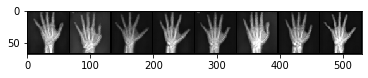

Epoch: 45	Batch: 496/497
Loss G: 5.803744792938232
Loss D: 0.09109904617071152
Epoch: 46/100
Example images:


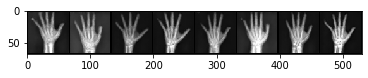

Epoch: 46	Batch: 496/497
Loss G: 3.0862624645233154
Loss D: 0.13549865782260895
Epoch: 47/100
Example images:


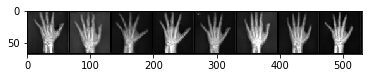

Epoch: 47	Batch: 496/497
Loss G: 6.657933235168457
Loss D: 0.013028524816036224
Epoch: 48/100
Example images:


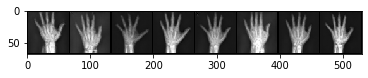

Epoch: 48	Batch: 496/497
Loss G: 9.813345909118652
Loss D: 0.011340402066707611
Epoch: 49/100
Example images:


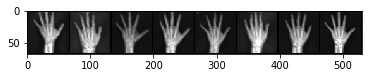

Epoch: 49	Batch: 496/497
Loss G: 9.845622062683105
Loss D: 0.601338803768158
Epoch: 50/100
Example images:


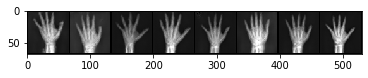

Epoch: 50	Batch: 496/497
Loss G: 5.893930435180664
Loss D: 0.14710065722465515
Epoch: 51/100
Example images:


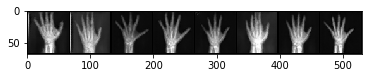

Epoch: 51	Batch: 496/497
Loss G: 5.621716022491455
Loss D: 0.13787004351615906
Epoch: 52/100
Example images:


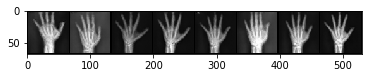

Epoch: 52	Batch: 496/497
Loss G: 6.867373943328857
Loss D: 0.15834979712963104
Epoch: 53/100
Example images:


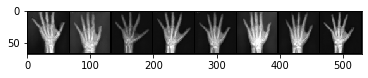

Epoch: 53	Batch: 496/497
Loss G: 8.920238494873047
Loss D: 0.38471493124961853
Epoch: 54/100
Example images:


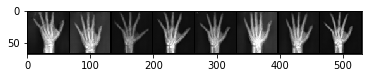

Epoch: 54	Batch: 496/497
Loss G: 15.320094108581543
Loss D: 0.5515215992927551
Epoch: 55/100
Example images:


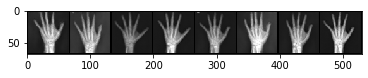

Epoch: 55	Batch: 496/497
Loss G: 11.111485481262207
Loss D: 0.0002975266252178699
Epoch: 56/100
Example images:


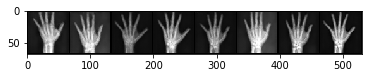

Epoch: 56	Batch: 496/497
Loss G: 11.396894454956055
Loss D: 0.46983659267425537
Epoch: 57/100
Example images:


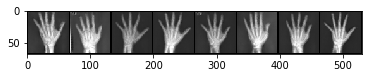

Epoch: 57	Batch: 496/497
Loss G: 14.206969261169434
Loss D: 0.04711371660232544
Epoch: 58/100
Example images:


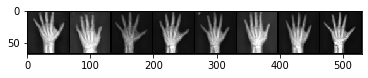

Epoch: 58	Batch: 496/497
Loss G: 8.602225303649902
Loss D: 0.0005286504165269434
Epoch: 59/100
Example images:


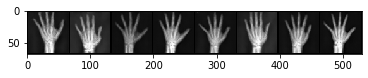

Epoch: 59	Batch: 496/497
Loss G: 6.971592903137207
Loss D: 0.007821538485586643
Epoch: 60/100
Example images:


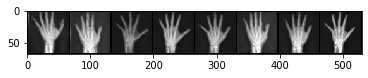

Epoch: 60	Batch: 496/497
Loss G: 5.584348201751709
Loss D: 0.009765639901161194
Epoch: 61/100
Example images:


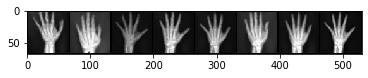

Epoch: 61	Batch: 496/497
Loss G: 11.660929679870605
Loss D: 0.7112461924552917
Epoch: 62/100
Example images:


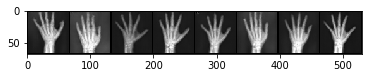

Epoch: 62	Batch: 496/497
Loss G: 6.048004150390625
Loss D: 0.019859181717038155
Epoch: 63/100
Example images:


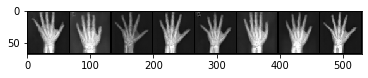

Epoch: 63	Batch: 496/497
Loss G: 8.689584732055664
Loss D: 0.01367177814245224
Epoch: 64/100
Example images:


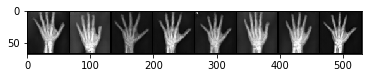

Epoch: 64	Batch: 496/497
Loss G: 6.958396911621094
Loss D: 0.11272319406270981
Epoch: 65/100
Example images:


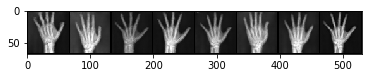

Epoch: 65	Batch: 496/497
Loss G: 5.426924228668213
Loss D: 0.02899845689535141
Epoch: 66/100
Example images:


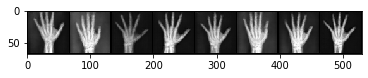

Epoch: 66	Batch: 496/497
Loss G: 12.983131408691406
Loss D: 0.004194971174001694
Epoch: 67/100
Example images:


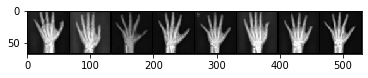

Epoch: 67	Batch: 496/497
Loss G: 6.550258636474609
Loss D: 0.05390182137489319
Epoch: 68/100
Example images:


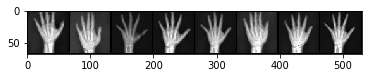

Epoch: 68	Batch: 496/497
Loss G: 13.437944412231445
Loss D: 0.003490935079753399
Epoch: 69/100
Example images:


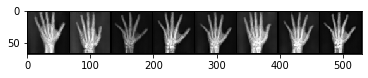

Epoch: 69	Batch: 496/497
Loss G: 10.787418365478516
Loss D: 0.002625968772917986
Epoch: 70/100
Example images:


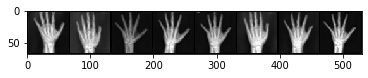

Epoch: 70	Batch: 496/497
Loss G: 6.500967502593994
Loss D: 0.009287801571190357
Epoch: 71/100
Example images:


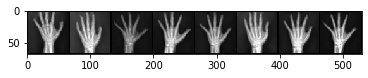

Epoch: 71	Batch: 496/497
Loss G: 9.845389366149902
Loss D: 0.10574708133935928
Epoch: 72/100
Example images:


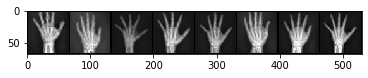

Epoch: 72	Batch: 496/497
Loss G: 8.482967376708984
Loss D: 0.10429411381483078
Epoch: 73/100
Example images:


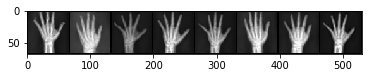

Epoch: 73	Batch: 496/497
Loss G: 6.135634422302246
Loss D: 0.06801602244377136
Epoch: 74/100
Example images:


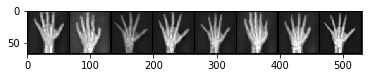

Epoch: 74	Batch: 496/497
Loss G: 10.702746391296387
Loss D: 0.007218560203909874
Epoch: 75/100
Example images:


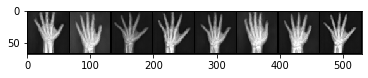

Epoch: 75	Batch: 496/497
Loss G: 8.278862953186035
Loss D: 0.07525651156902313
Epoch: 76/100
Example images:


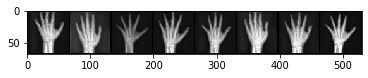

Epoch: 76	Batch: 496/497
Loss G: 11.50492000579834
Loss D: 0.0002799562644213438
Epoch: 77/100
Example images:


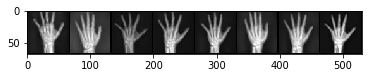

Epoch: 77	Batch: 496/497
Loss G: 7.7790985107421875
Loss D: 0.0942598283290863
Epoch: 78/100
Example images:


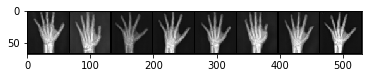

Epoch: 78	Batch: 496/497
Loss G: 4.766053199768066
Loss D: 0.02641199715435505
Epoch: 79/100
Example images:


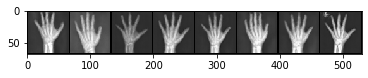

Epoch: 79	Batch: 496/497
Loss G: 10.038304328918457
Loss D: 0.21472032368183136
Epoch: 80/100
Example images:


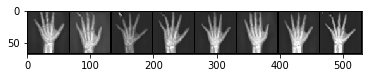

Epoch: 80	Batch: 496/497
Loss G: 15.954002380371094
Loss D: 0.024978183209896088
Epoch: 81/100
Example images:


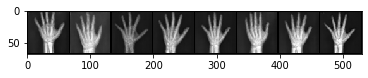

Epoch: 81	Batch: 496/497
Loss G: 19.48118782043457
Loss D: 0.0009211587021127343
Epoch: 82/100
Example images:


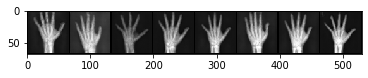

Epoch: 82	Batch: 496/497
Loss G: 6.453575134277344
Loss D: 0.01135014183819294
Epoch: 83/100
Example images:


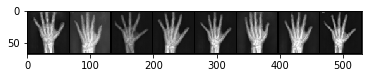

Epoch: 83	Batch: 496/497
Loss G: 7.689891338348389
Loss D: 0.04308810085058212
Epoch: 84/100
Example images:


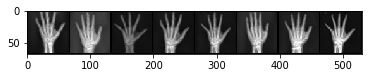

Epoch: 84	Batch: 496/497
Loss G: 17.315458297729492
Loss D: 0.39061757922172546
Epoch: 85/100
Example images:


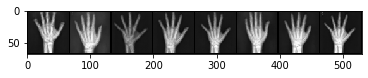

Epoch: 85	Batch: 496/497
Loss G: 11.752623558044434
Loss D: 0.0016280715353786945
Epoch: 86/100
Example images:


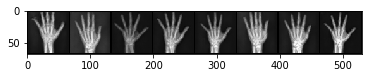

Epoch: 86	Batch: 496/497
Loss G: 11.044678688049316
Loss D: 4.806834112969227e-05
Epoch: 87/100
Example images:


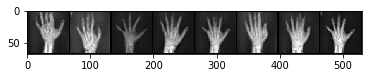

Epoch: 87	Batch: 496/497
Loss G: 8.978140830993652
Loss D: 0.008046413771808147
Epoch: 88/100
Example images:


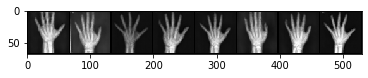

Epoch: 88	Batch: 496/497
Loss G: 17.859296798706055
Loss D: 0.0017293806886300445
Epoch: 89/100
Example images:


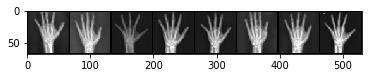

Epoch: 89	Batch: 496/497
Loss G: 5.960385799407959
Loss D: 0.034578241407871246
Epoch: 90/100
Example images:


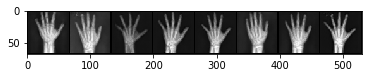

Epoch: 90	Batch: 496/497
Loss G: 13.57138729095459
Loss D: 0.1422835886478424
Epoch: 91/100
Example images:


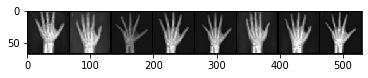

Epoch: 91	Batch: 496/497
Loss G: 8.927000999450684
Loss D: 0.0038875972386449575
Epoch: 92/100
Example images:


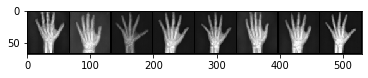

Epoch: 92	Batch: 496/497
Loss G: 11.506346702575684
Loss D: 8.443425031146035e-05
Epoch: 93/100
Example images:


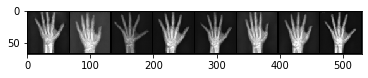

Epoch: 93	Batch: 496/497
Loss G: 9.660629272460938
Loss D: 0.31784728169441223
Epoch: 94/100
Example images:


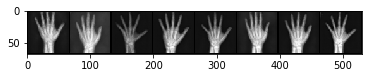

Epoch: 94	Batch: 496/497
Loss G: 6.5265212059021
Loss D: 0.015280339866876602
Epoch: 95/100
Example images:


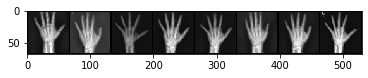

Epoch: 95	Batch: 496/497
Loss G: 6.3852972984313965
Loss D: 0.04559633880853653
Epoch: 96/100
Example images:


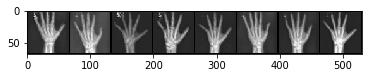

Epoch: 96	Batch: 496/497
Loss G: 6.390835762023926
Loss D: 0.02687714621424675
Epoch: 97/100
Example images:


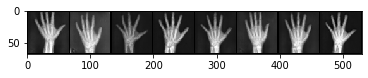

Epoch: 97	Batch: 496/497
Loss G: 8.434618949890137
Loss D: 0.00325696705840528
Epoch: 98/100
Example images:


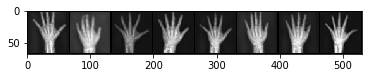

Epoch: 98	Batch: 496/497
Loss G: 10.073137283325195
Loss D: 0.0027430301997810602
Epoch: 99/100
Example images:


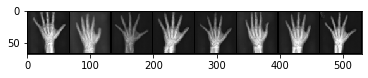

Epoch: 99	Batch: 496/497
Loss G: 9.933619499206543
Loss D: 0.07987196743488312


In [ ]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch}/{n_epochs}")
    print("Example images:")
    generated_images = G(test_noise).detach().cpu()
    show_images(generated_images)
    
    for i, (batch, _) in enumerate(data_loader):
        print(f"\rEpoch: {epoch}\tBatch: {i}/{len(data_loader)}", end='')
        ####
        D.zero_grad()

        #
        real = Variable(batch).to(gpu)
        real_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
        real_predictions = D(real)
        d_error_real = compute_loss(real_predictions, real_labels)
        
        # 
        noise = Variable(torch.randn(real.size(0), 100, 1, 1)).to(gpu)
        fake = G(noise)
        fake_predictions = D(fake.detach())
        fake_labels = Variable(torch.zeros(real.size(0), 1, 1, 1)).to(gpu)
        d_error_fake = compute_loss(fake_predictions, fake_labels)
        
        # 
        d_error_total = d_error_real + d_error_fake
        d_error_total.backward()
        optimizer_d.step()
        
        ####
        G.zero_grad()
        
        # 
        goal_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
        results = D(fake)
        g_error = compute_loss(results, goal_labels)
        
        # 
        g_error.backward()
        optimizer_g.step()
    
    print("")
    print(f"Loss G: {g_error}")
    print(f"Loss D: {d_error_total}")

In [ ]:
# torch.save(G.state_dict(), "tmdhey_trained_generator")
# torch.save(D.state_dict(), "tmdhey_trained_discriminator")

In [ ]:
torch.save(G.state_dict(), "/content/drive/MyDrive/cakd_colab/python_practice/tmdhey_trained_generator_3")
torch.save(D.state_dict(), "/content/drive/MyDrive/cakd_colab/python_practice/tmdhey_trained_discriminator_3")

# Try trained GAN

In [ ]:
import torchvision
import torch
from torch import nn

In [ ]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100, 
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            
            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            
            # Output Layer
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.main(x)
        return x

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images):
    img = torchvision.utils.make_grid(images, normalize=True)
    npy_img = img.numpy()
    plt.imshow(np.transpose(npy_img, (1, 2, 0)),
               interpolation='nearest')
    plt.show()

In [ ]:
G = Generator()
G.load_state_dict(torch.load('/content/drive/MyDrive/cakd_colab/python_practice/tmdhey_trained_generator_2'))

<All keys matched successfully>

In [1]:
noise = torch.randn(48, 100, 1, 1)

images = G(noise).detach()
images.shape

show_images(images)